# Predictive Maintenance using Turbofan Engine Degradation Data

**Author**: Harithik Rai

**Date**: January 2026

## 🎯 Project Goal

Develop a machine learning model to predict Remaining Useful Life (RUL) of turbofan engines using sensor data, enabling proactive maintenance scheduling and reducing unplanned downtime in aviation operations.

## Dataset Overview

This project uses the **NASA C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) FD001 dataset**, which simulates run-to-failure trajectories of turbofan engines under controlled conditions.

- **Source**: NASA Prognostics Center of Excellence: https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/
- **Engines**: 100 training units, 100 test units
- **Operating Conditions**: Single flight regime (sea level)
- **Fault Modes**: Single failure mode (High-Pressure Compressor degradation)
- **Sensor Measurements**: 21 sensors recording temperature, pressure, speed, and other operational parameters
- **Target Variable**: Remaining Useful Life (RUL) - cycles remaining until engine failure

Each engine in the training set operates normally at the start and gradually degrades until failure. The test set contains engines with unknown RUL that must be predicted based on partial degradation histories.

## Methodology

1. **Exploratory Data Analysis**: Examine sensor behavior, identify degradation patterns, and assess data quality
2. **Feature Engineering**: Extract time-series features, compute degradation indicators, and engineer RUL labels
3. **Model Development**: Train XGBoost regressor to predict RUL with hyperparameter tuning
4. **Evaluation**: Assess performance using RMSE and custom asymmetric scoring function (penalizes late predictions more heavily)
5. **Feature Importance Analysis**: Identify which sensors are most predictive of engine health using XGBoost's built-in feature importance metrics

## Limitations

- **Simplified simulation**: Real engines face multiple operating conditions and failure modes simultaneously
- **Single fault mode**: Model trained on HPC degradation may not generalize to other failure types
- **Sensor noise**: Simulated data may not fully capture real-world measurement variability

## Hypothesis

By analyzing sensor degradation patterns and building RUL prediction models, this project demonstrates:
- Time-series feature engineering for prognostic applications
- Gradient boosting (XGBoost) for regression in maintenance contexts
- Practical deployment considerations for predictive maintenance systems

**Key Question**: Can multivariate sensor data accurately predict when an aircraft engine will fail, allowing maintenance teams to intervene before catastrophic breakdowns?

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Set visualization style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# Suppress the warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define project paths
PROJECT_ROOT = Path("../")
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "CMAPSSData"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
TRAIN_FILE = DATA_DIR / "train_FD001.txt"

## 1. Dataset Schema

The C-MAPSS dataset contains:
- **engine_id**: Unit identifier (1-100 for FD001)
- **cycle**: Time in cycles (operational timestamp)
- **op_setting_1-3**: Operational settings (flight conditions)
- **sensor_1-21**: Sensor measurements from various engine components

In [3]:
# Define column names
columns = (
    ["engine_id", "cycle"] +
    [f"op_setting_{i}" for i in range(1, 4)] +
    [f"sensor_{i}" for i in range(1, 22)]
)

print(f"Total columns: {len(columns)}")
print(f"Sensor columns: {len([c for c in columns if 'sensor' in c])}")

Total columns: 26
Sensor columns: 21


## 2. Data Loading

**IMPORTANT**: The original C-MAPSS files are space-delimited with potential 
trailing spaces. I use `delim_whitespace=True` to handle this correctly.

In [4]:
# Load training data with proper delimiter
train = pd.read_csv(
    TRAIN_FILE,
    sep=r'\s+',  # Whitespace delimiter
    header=None,
    names=columns,
    engine='python'
)

# Display basic info for few rows
print(f"Dataset shape: {train.shape}")
print(f"\nFirst few rows:")
train.head()

Dataset shape: (20631, 26)

First few rows:


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## 3. Data Quality Checks

In [5]:
print("Data Types:")
print(train.dtypes.value_counts())

# Check for missing values
print(f"\nMissing values: {train.isnull().sum().sum()}")

# Validate engine IDs and cycles are integers
assert train['engine_id'].dtype in [int, np.int64], "engine_id should be integer"
assert train['cycle'].dtype in [int, np.int64], "cycle should be integer"

# Basic statistics
print("\nDataset Summary:")
print(f"Number of engines: {train['engine_id'].nunique()}")
print(f"Total observations: {len(train)}")
print(f"Average cycles per engine: {len(train) / train['engine_id'].nunique():.1f}")
print(f"Min cycles: {train.groupby('engine_id')['cycle'].max().min()}")
print(f"Max cycles: {train.groupby('engine_id')['cycle'].max().max()}")

Data Types:
float64    22
int64       4
Name: count, dtype: int64

Missing values: 0

Dataset Summary:
Number of engines: 100
Total observations: 20631
Average cycles per engine: 206.3
Min cycles: 128
Max cycles: 362


## 4. Engine Lifecycle Analysis

Examining the distribution of engine lifespans (total cycles before failure).

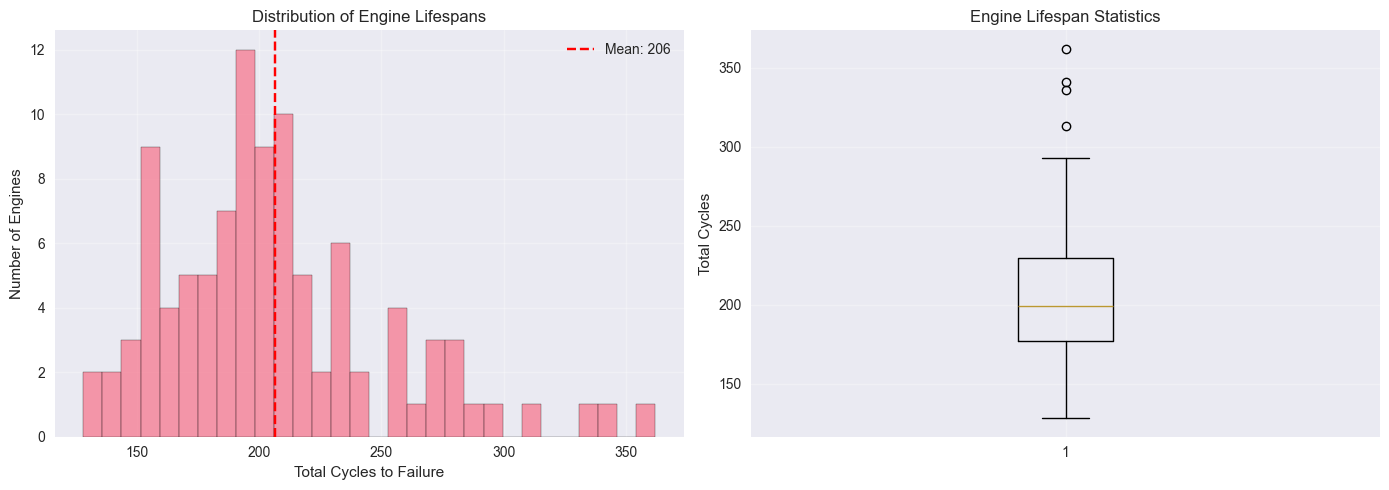

Lifespan Statistics:
count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: cycle, dtype: float64


In [6]:
# Calculate engine lifespans
engine_lifespans = train.groupby('engine_id')['cycle'].max()

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(engine_lifespans, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(engine_lifespans.mean(), color='red', linestyle='--', 
                label=f'Mean: {engine_lifespans.mean():.0f}')
axes[0].set_xlabel('Total Cycles to Failure')
axes[0].set_ylabel('Number of Engines')
axes[0].set_title('Distribution of Engine Lifespans')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(engine_lifespans)
axes[1].set_ylabel('Total Cycles')
axes[1].set_title('Engine Lifespan Statistics')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Lifespan Statistics:")
print(engine_lifespans.describe())

## 5. Remaining Useful Life (RUL) Target

Remaining Useful Life (RUL) is computed as the difference between the maximum observed cycle for each engine and the current cycle.

This formulation reflects a standard predictive maintenance setup where degradation accumulates monotonically over time, and RUL decreases linearly as failure approaches.

**Formula**: RUL = max_cycle_for_engine - current_cycle

In [7]:
# Calculate RUL for each observation
max_cycles = train.groupby('engine_id')['cycle'].transform('max')
train['RUL'] = max_cycles - train['cycle']

# Verify RUL calculation
sample_engine = train[train['engine_id'] == 1][['engine_id', 'cycle', 'RUL']].head(10)
print("Sample RUL calculation (Engine 1):")
print(sample_engine)

Sample RUL calculation (Engine 1):
   engine_id  cycle  RUL
0          1      1  191
1          1      2  190
2          1      3  189
3          1      4  188
4          1      5  187
5          1      6  186
6          1      7  185
7          1      8  184
8          1      9  183
9          1     10  182


## 6. RUL Distribution Analysis

The RUL distribution shows a wide range of values, with many samples corresponding to early-life engine operation and fewer samples near failure.

This imbalance is typical in run-to-failure datasets and motivates later techniques such as RUL capping and engine-wise validation to prevent biased learning.

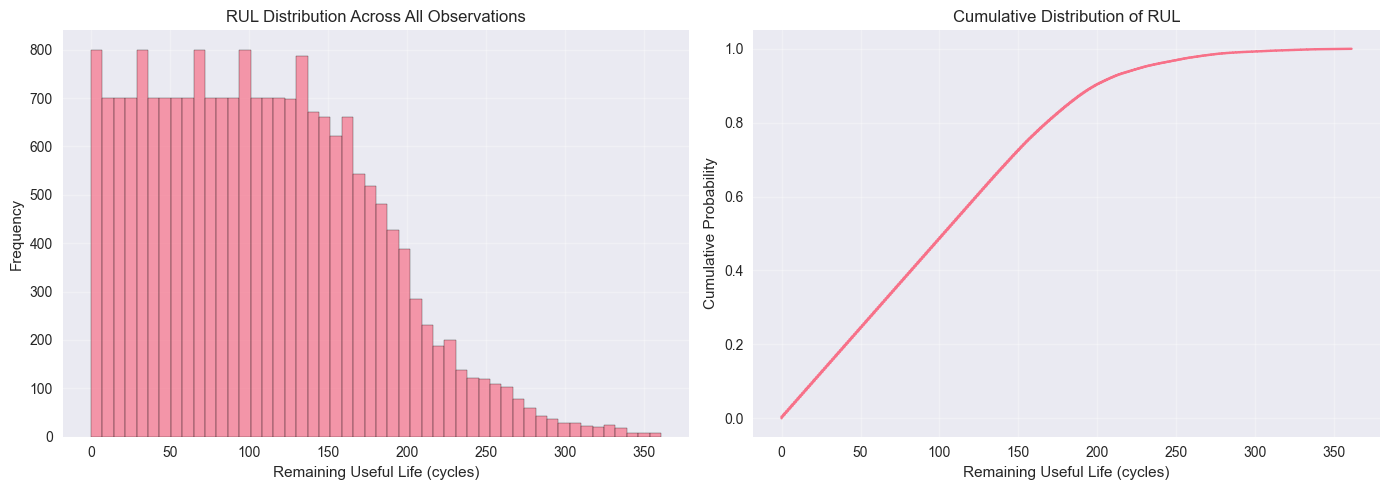

RUL Statistics:
count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(train['RUL'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Remaining Useful Life (cycles)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('RUL Distribution Across All Observations')
axes[0].grid(alpha=0.3)

# CDF
sorted_rul = np.sort(train['RUL'])
cdf = np.arange(1, len(sorted_rul) + 1) / len(sorted_rul)
axes[1].plot(sorted_rul, cdf)
axes[1].set_xlabel('Remaining Useful Life (cycles)')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('Cumulative Distribution of RUL')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("RUL Statistics:")
print(train['RUL'].describe())

## 7. Feature Selection: Variance Analysis

Sensor variance analysis reveals that only a subset of sensors exhibit meaningful variation over time. Several sensors remain nearly constant across all engines and cycles, indicating limited predictive value.

Sensors with minimal variance are unlikely to contribute useful information for Remaining Useful Life prediction and may be excluded or deprioritized during feature engineering.

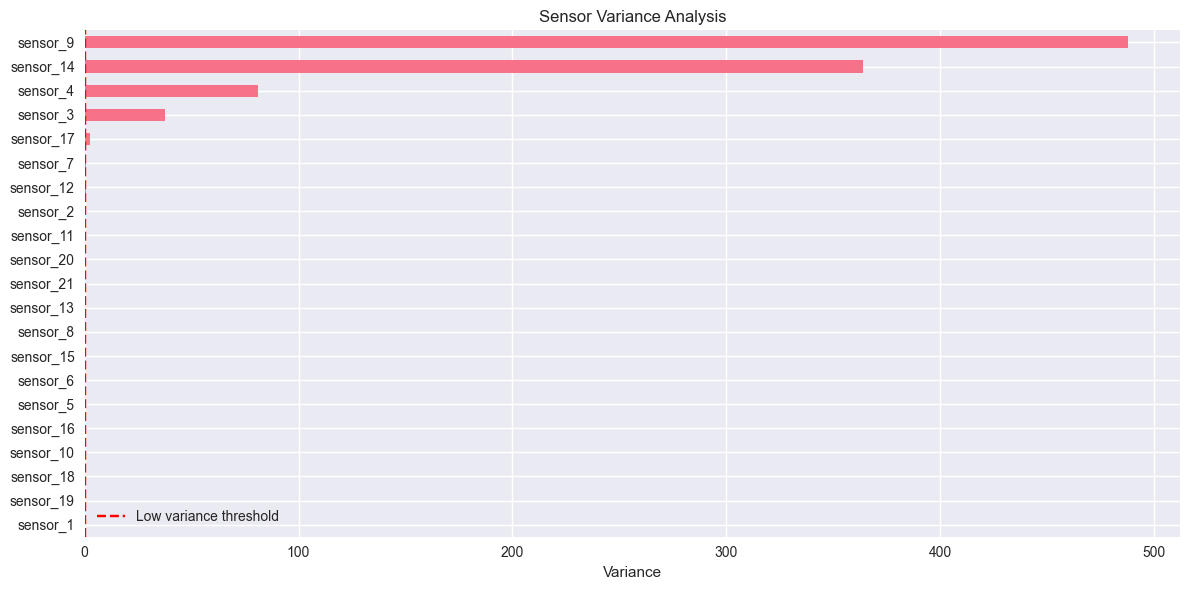

Sensor Variance (sorted):
sensor_1     0.000000e+00
sensor_19    0.000000e+00
sensor_18    0.000000e+00
sensor_10    0.000000e+00
sensor_16    1.926023e-34
sensor_5     3.155597e-30
sensor_6     1.929279e-06
sensor_15    1.406628e-03
sensor_8     5.038938e-03
sensor_13    5.172330e-03
sensor_21    1.171825e-02
sensor_20    3.266927e-02
sensor_11    7.133568e-02
sensor_2     2.500533e-01
sensor_12    5.439850e-01
sensor_7     7.833883e-01
sensor_17    2.398667e+00
sensor_3     3.759099e+01
sensor_4     8.101089e+01
sensor_14    3.639005e+02
sensor_9     4.876536e+02
dtype: float64


In [9]:
# Calculate variance for all sensors
sensor_cols = [col for col in train.columns if col.startswith('sensor_')]
sensor_variance = train[sensor_cols].var().sort_values()

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
sensor_variance.plot(kind='barh', ax=ax)
ax.set_xlabel('Variance')
ax.set_title('Sensor Variance Analysis')
ax.axvline(0.01, color='red', linestyle='--', label='Low variance threshold')
ax.legend()
plt.tight_layout()
plt.show()

print("Sensor Variance (sorted):")
print(sensor_variance)

## 8. Feature Engineering: Remove Uninformative Sensors

Based on variance analysis and domain knowledge from C-MAPSS studies,
we remove sensors with minimal variation.

In [10]:
# Define low-variance sensors
LOW_VARIANCE_THRESHOLD = 1e-6
low_variance_sensors = sensor_variance[sensor_variance < LOW_VARIANCE_THRESHOLD].index.tolist()

# Also include sensors commonly removed in literature
LITERATURE_REMOVALS = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 
                       'sensor_16', 'sensor_18', 'sensor_19']

# Combine both approaches
sensors_to_remove = list(set(low_variance_sensors + LITERATURE_REMOVALS))
sensors_to_remove.sort()

print(f"Removing {len(sensors_to_remove)} sensors:")
print(sensors_to_remove)

# Create reduced dataset
train_reduced = train.drop(columns=sensors_to_remove)

remaining_sensors = [col for col in train_reduced.columns if col.startswith('sensor_')]
print(f"\nRemaining sensors ({len(remaining_sensors)}):")
print(remaining_sensors)

Removing 7 sensors:
['sensor_1', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19', 'sensor_5', 'sensor_6']

Remaining sensors (14):
['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']


## 9. Sensor Degradation Behavior

Visual inspection of sensor trajectories for individual engines shows clear degradation patterns in select sensors as failure approaches.

While individual sensor trends may appear noisy, the collective behavior across multiple sensors provides a signal that can be learned by tree-based models such as XGBoost.

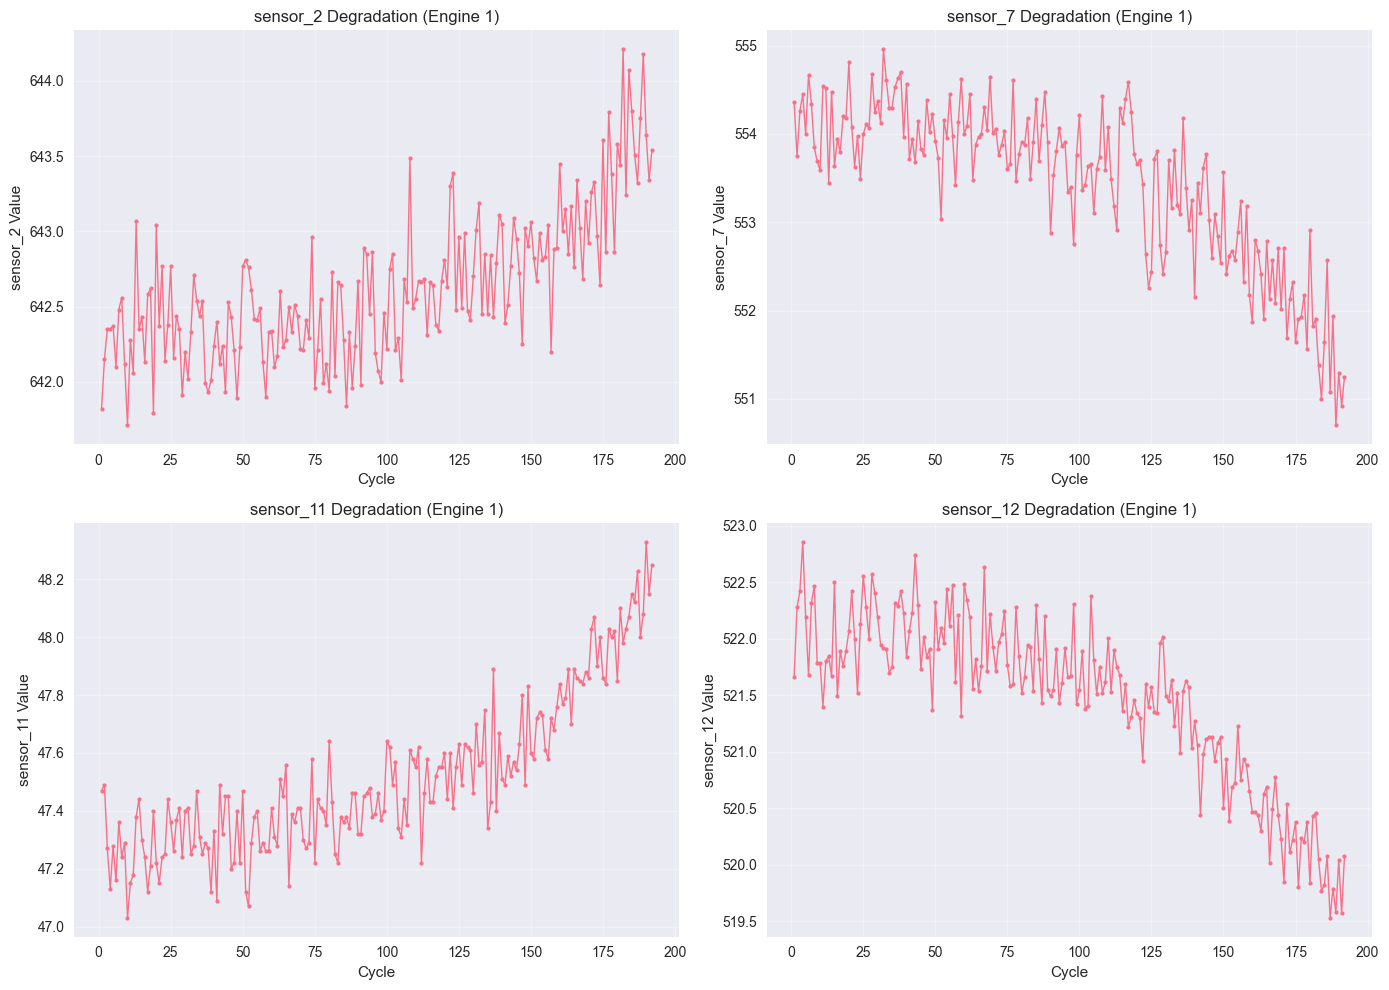

In [11]:
# Select example engine
example_engine_id = 1
engine_data = train_reduced[train_reduced['engine_id'] == example_engine_id]

# Select diverse sensors for visualization
sensors_to_plot = ['sensor_2', 'sensor_7', 'sensor_11', 'sensor_12']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, sensor in enumerate(sensors_to_plot):
    axes[idx].plot(engine_data['cycle'], engine_data[sensor], 
                   marker='o', markersize=3, linewidth=1)
    axes[idx].set_xlabel('Cycle')
    axes[idx].set_ylabel(f'{sensor} Value')
    axes[idx].set_title(f'{sensor} Degradation (Engine {example_engine_id})')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Feature Correlation

Understanding relationships between sensors and RUL to identify
highly correlated features.

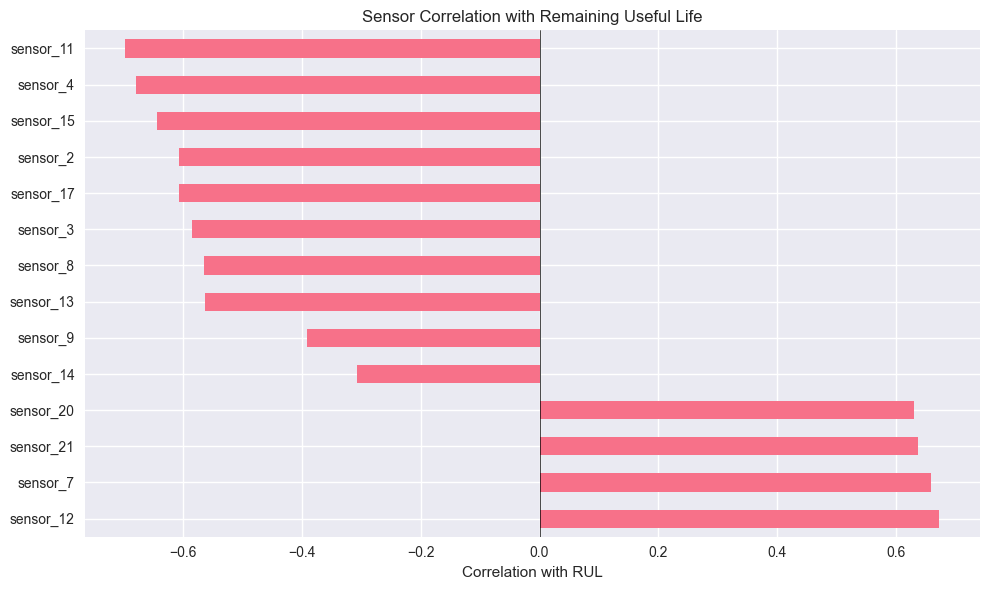

Top 5 positively correlated sensors:
sensor_12    0.671983
sensor_7     0.657223
sensor_21    0.635662
sensor_20    0.629428
sensor_14   -0.306769
Name: RUL, dtype: float64

Top 5 negatively correlated sensors:
sensor_17   -0.606154
sensor_2    -0.606484
sensor_15   -0.642667
sensor_4    -0.678948
sensor_11   -0.696228
Name: RUL, dtype: float64


In [12]:
# Calculate correlations with RUL
rul_correlations = train_reduced[remaining_sensors + ['RUL']].corr()['RUL'].drop('RUL').sort_values(ascending=False)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
rul_correlations.plot(kind='barh', ax=ax)
ax.set_xlabel('Correlation with RUL')
ax.set_title('Sensor Correlation with Remaining Useful Life')
ax.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

print("Top 5 positively correlated sensors:")
print(rul_correlations.head())
print("\nTop 5 negatively correlated sensors:")
print(rul_correlations.tail())

## 11. Operating Conditions

FD001 operates under a single condition, but I verify this assumption here.

In [13]:
# Check operating settings variability
op_settings = ['op_setting_1', 'op_setting_2', 'op_setting_3']

for setting in op_settings:
    unique_vals = train[setting].nunique()
    print(f"{setting}: {unique_vals} unique values")
    if unique_vals <= 10:
        print(f"  Values: {train[setting].unique()}")

op_setting_1: 158 unique values
op_setting_2: 13 unique values
op_setting_3: 1 unique values
  Values: [100.]


## 12. Final Dataset Preparation

Creating the cleaned dataset for modeling with:
- Engine identifiers
- Temporal information (cycle)
- Informative sensor readings
- Operating conditions
- RUL target variable

In [14]:
# Define final column order
FINAL_COLUMNS = (
    ['engine_id', 'cycle'] +
    op_settings +
    remaining_sensors +
    ['RUL']
)

final_df = train_reduced[FINAL_COLUMNS]

print(f"Final dataset shape: {final_df.shape}")
print(f"Features: {len(final_df.columns) - 3}")  # Excluding engine_id, cycle, RUL
print("\nColumn summary:")
print(f"  - Identifiers: engine_id, cycle")
print(f"  - Operating settings: {len(op_settings)}")
print(f"  - Sensors: {len(remaining_sensors)}")
print(f"  - Target: RUL")

final_df.head()

Final dataset shape: (20631, 20)
Features: 17

Column summary:
  - Identifiers: engine_id, cycle
  - Operating settings: 3
  - Sensors: 14
  - Target: RUL


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


## 13. Export Cleaned Dataset

In [15]:
# Create output directory if needed
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Save to CSV
output_file = PROCESSED_DIR / "fd001_clean.csv"
final_df.to_csv(output_file, index=False)

print(f"Cleaned dataset saved to: {output_file}")
print(f"Total observations: {len(final_df):,}")
print(f"Features: {len(final_df.columns) - 3}")

Cleaned dataset saved to: ..\data\processed\fd001_clean.csv
Total observations: 20,631
Features: 17


## Summary

**Key Findings:**


**Next Steps:**
